<a href="https://colab.research.google.com/github/nsandlin1/EEG_Mining/blob/main/EEG_Mining_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link to data files: https://bbci.de/competition/iii/#data_set_v

# Setting up data files

### Refactor from ascii (.asc) to csv (.csv)

```
perl -i -pe 's/(?<=\d)   (?=\d)/,/g' train*
perl -i -pe 's/^   //g' train*

perl -i -pe 's/(?<=\d)  (?=\d)/,/g' test*
perl -i -pe 's/^  //g' test*

for FILENAME in *.asc; do mv "$FILENAME" "${FILENAME%.asc}"; done
for FILENAME in *; do mv "$FILENAME" "${FILENAME}.csv"; done
```

### Import files

In [2]:
# upload files
from google.colab import files
uploaded = files.upload()

Saving train_subject1_psd01.csv to train_subject1_psd01.csv
Saving train_subject1_psd02.csv to train_subject1_psd02.csv
Saving train_subject1_psd03.csv to train_subject1_psd03.csv


In [3]:
# import files to pd dataframe
import pandas as pd
train_subject1_psd01 = pd.read_csv('train_subject1_psd01.csv', header=None)
train_subject1_psd02 = pd.read_csv('train_subject1_psd02.csv', header=None)
train_subject1_psd03 = pd.read_csv('train_subject1_psd03.csv', header=None)
train_subject1 = pd.concat([train_subject1_psd01, train_subject1_psd02, train_subject1_psd03])
# train_subject2_psd01 = pd.read_csv('train_subject2_psd01.csv', header=None)
# train_subject2_psd02 = pd.read_csv('train_subject2_psd02.csv', header=None)
# train_subject2_psd03 = pd.read_csv('train_subject2_psd03.csv', header=None)
# train_subject3_psd01 = pd.read_csv('train_subject3_psd01.csv', header=None)
# train_subject3_psd02 = pd.read_csv('train_subject3_psd02.csv', header=None)
# train_subject3_psd03 = pd.read_csv('train_subject3_psd03.csv', header=None)

# Data Visualization

<Axes: >

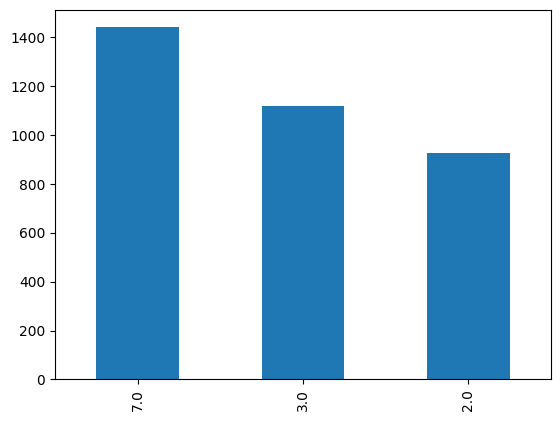

In [ ]:
# view occurance of different actions
# actions are specified by column 97
train_subject1_psd01[96].value_counts().plot(kind='bar')

<Axes: xlabel='0'>

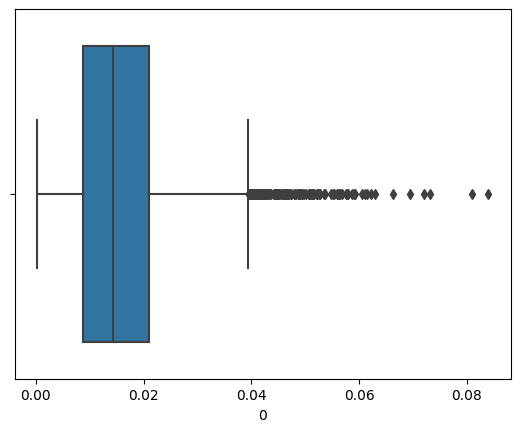

In [43]:
import seaborn as sns
sns.boxplot(data=train_subject1_psd01, x=0)

# Preprocessing

In [ ]:
# function for checking nulls in df
def check_for_nulls(df, verbose=False):
  nulls = df.isnull().sum()

  if verbose:
    zeros = {}
    for key,value in nulls.items():
        zeros[key] = value
    return zeros
  else:
    return nulls

In [ ]:
check_for_nulls(train_subject1_psd01)

0     0
1     0
2     0
3     0
4     0
     ..
92    0
93    0
94    0
95    0
96    0
Length: 97, dtype: int64

### Analysis of Multicolinearity

In [20]:
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

from statsmodels.stats.outliers_influence import variance_inflation_factor

# dataframe for independent variables
independents = train_subject1_psd01[[i for i in range(0, 96)]]

# VIF dataframe
vifs = pd.DataFrame()

# calculate VIF for each attribute
vifs["VIF"] = [variance_inflation_factor(independents.values, i) for i in range(len(independents.columns))]

print(vifs[vifs.VIF < 6])
print(vifs[vifs.VIF > 15])

         VIF
0   5.502826
11  5.828397
23  5.756342
35  5.946383
95  5.186868
          VIF
25  20.390979


# Data Mining

In [28]:
from sklearn.model_selection import train_test_split

# define independent and dependent variable subsets for training
independents = train_subject1_psd01.drop(96, axis=1)
dependents = train_subject1_psd01[96]

# partition training and testing sets
ind_train, ind_test, dep_train, dep_test = train_test_split(independents, dependents, test_size=0.2)

### Linear Regression

In [41]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# train using all attributes
# instantiate the model
regr_all = linear_model.LinearRegression()

# regress
regr_all.fit(ind_train, dep_train)

# train using all attributes
dep_pred_all = regr_all.predict(ind_test)

print("all:")
# compute accuracy of model
print("Coefficients: \n", regr_all.coef_)
# mean squared error
print(f"MSE: {mean_squared_error(dep_test, dep_pred_all)}")
# coefficient of determination: 1 is perfect prediction
print(f"r^2: {r2_score(dep_test, dep_pred_all)}")

#####################################################
# Multicolinearity dimensionality reduction failed.
#####################################################

# train using attributes with low multicolinearity as per VIF
# those values with the lowest VIF, < 6, were columns 0, 11, 23, 35, & 95
# constrict training data to those attributes
ind_train_VIF_restricted = ind_train[[0, 11, 23, 35, 95]]
ind_test_VIF_restricted = ind_test[[0, 11, 23, 35, 95]]

# instantiate the model
regr_VIF_restricted = linear_model.LinearRegression()

# regress
regr_VIF_restricted.fit(ind_train_VIF_restricted, dep_train)

# train using restricted attributes
dep_pred_VIF_restricted = regr_VIF_restricted.predict(ind_test_VIF_restricted)

print("\nVIF restricted:")
# compute accuracy of model
print("Coefficients: \n", regr_VIF_restricted.coef_)
# mean squared error
print(f"MSE: {mean_squared_error(dep_test, dep_pred_VIF_restricted)}")
# coefficient of determination: 1 is perfect prediction
print(f"r^2: {r2_score(dep_test, dep_pred_VIF_restricted)}")


all:
Coefficients: 
 [3586624.44474608 3586613.53618108 3586582.24145176 3586656.90069235
 3586596.80290214 3586623.96530954 3586700.32652153 3586569.65466346
 3586661.17529643 3586637.28906769 3586670.22870935 3586571.93736175
 3586629.88702147 3586627.22865942 3586635.23530059 3586578.42113068
 3586580.23889025 3586681.21231472 3586536.24326029 3586733.66575964
 3586545.60193556 3586657.40256013 3586721.93342443 3586678.45940353
 3586622.83682552 3586615.8297794  3586626.87760379 3586602.74899914
 3586637.63958994 3586602.94445631 3586643.31788436 3586574.33480954
 3586676.82440865 3586602.72562931 3586605.67600521 3586548.98602845
 3586600.37064541 3586662.42446531 3586654.04623467 3586604.25489431
 3586596.45512874 3586615.63564374 3586580.68292655 3586664.01879831
 3586542.55958917 3586724.00518651 3586511.36184525 3586671.78465413
 3586612.56059031 3586659.61818125 3586614.89113394 3586632.13906916
 3586549.45540436 3586619.9856727  3586653.49853224 3586598.39900747
 3586471.1741



### Random Forest

acc: 0.9541547277936963


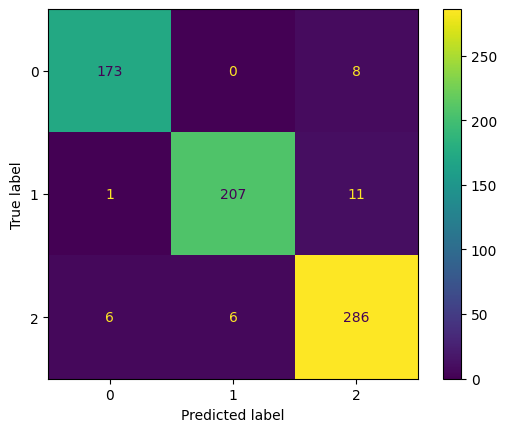

In [8]:
# https://www.datacamp.com/tutorial/random-forests-classifier-python

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# fit the random forest model
##### TODO: Hyperparameter tuning
rf = RandomForestClassifier()
rf.fit(ind_train, dep_train)

# inference
dep_pred = rf.predict(ind_test)

# compute accuracy
acc = accuracy_score(dep_test, dep_pred)
print(f"acc: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test, dep_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


### SVM

acc: 0.8510028653295129


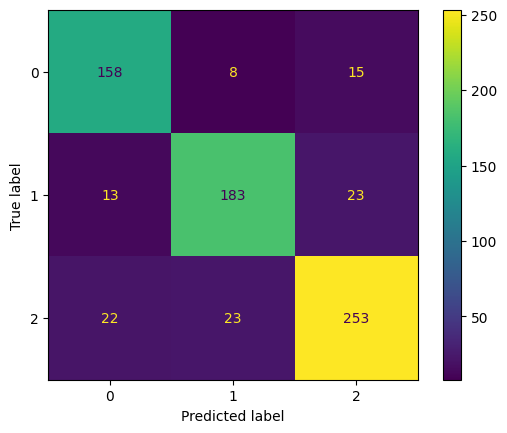

In [17]:
# https://holypython.com/svm/support-vector-machine-step-by-step/#google_vignette

from sklearn import svm

# instantiate svm
sup_vec_mach = svm.SVC(kernel='rbf')

# fit the SVM
sup_vec_mach.fit(ind_train, dep_train)

# inference
dep_pred = sup_vec_mach.predict(ind_test)

# compute accuracy
acc = accuracy_score(dep_test, dep_pred)
print(f"acc: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test, dep_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()